<a href="https://colab.research.google.com/github/vanadnarayane26/Text_to_SQL_Spider-/blob/main/VVN_Text_to_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installing libraries
!pip install -q datasets
!pip install -q transformers 
!pip install -q rouge_score
!pip install -q evaluate

     |████████████████████████████████| 451 kB 4.7 MB/s 
     |████████████████████████████████| 115 kB 68.1 MB/s 
     |████████████████████████████████| 212 kB 64.3 MB/s 
     |████████████████████████████████| 182 kB 58.7 MB/s 
     |████████████████████████████████| 127 kB 67.7 MB/s 
     |████████████████████████████████| 5.5 MB 4.8 MB/s 
     |████████████████████████████████| 7.6 MB 47.6 MB/s 
     |████████████████████████████████| 72 kB 1.4 MB/s 


In [ ]:
import pandas as pd
import nltk
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_metric, Dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
rouge_score = evaluate.load("rouge")

In [ ]:
df = pd.read_json('/content/train_spider.json')

In [ ]:
df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


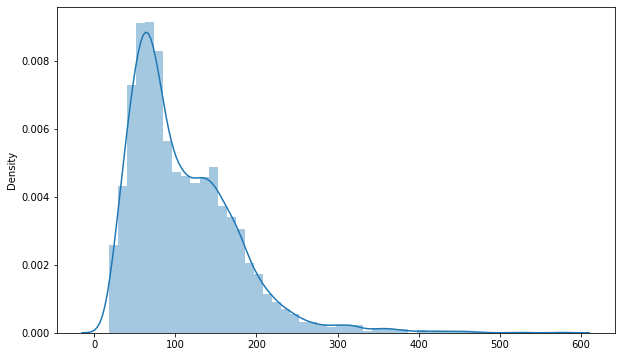

In [ ]:
# Checking the sequence lengths for queries in dataset
l = []
for i in df['query']:
  l.append(len(i))

plt.figure(figsize = (10,6))
sns.distplot(l)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


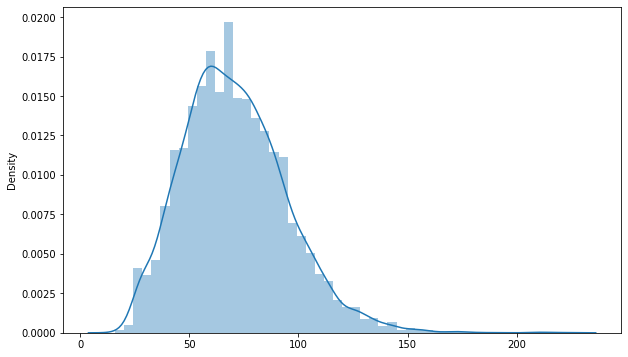

In [ ]:
# Checking the sequence length for questions in the dataset
l = []
for i in df['question']:
  l.append(len(i))

plt.figure(figsize = (10,6))
sns.distplot(l)
plt.show()

In [ ]:
df = df[['query','question']]

In [ ]:
# Splitting the dataset into training and validation set
train_df, val_df = train_test_split(df,test_size = 0.1, random_state = 21)
print(train_df.shape)
print(val_df.shape)

(6300, 2)
(700, 2)


In [ ]:
# Converting the pandas dataframe to huggingface datasets and drooping the index columns generated
rain_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['query', 'question'],
    num_rows: 6300
})
Dataset({
    features: ['query', 'question'],
    num_rows: 700
})


In [ ]:
train_dataset['query'][1]

'SELECT T2.team_id ,  T2.rank FROM home_game AS T1 JOIN team AS T2 ON T1.team_id  =  T2.team_id WHERE T1.year  =  2014 GROUP BY T1.team_id ORDER BY avg(T1.attendance) DESC LIMIT 1;'

In [ ]:
# downloading model from the checkpoint
from transformers import AutoTokenizer
model_checkpoint = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Preprocessing and defining the sequence length for training the models
max_input_length = 256
max_target_length = 256


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples['question'],
        max_length=max_input_length,
        truncation=True, padding = 'max_length'
    )
    labels = tokenizer(text_target = examples['query'], max_length=max_target_length, truncation=True,padding = 'max_length')
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["labels_mask"] = labels["attention_mask"]
    return model_inputs

In [ ]:
tokenized_train_datasets = train_dataset.map(preprocess_function, batched=True)

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
tokenized_val_datasets = val_dataset.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_train_datasets = tokenized_train_datasets.remove_columns(['query','question'])
tokenized_val_datasets = tokenized_val_datasets.remove_columns(['query','question'])

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(model = model,tokenizer = tokenizer,label_pad_token_id=-100)

In [ ]:
batch_size = 8
learning_rate = 1e-5
args = Seq2SeqTrainingArguments(
    "test-summary",
    evaluation_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=False,
    push_to_hub = False
)

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_val_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: labels_mask. If labels_mask are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6300
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2364
  Number of trainable parameters = 406290432
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than usi

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.513800,0.067949,49.563600,33.231800,44.831100,44.839500
2,0.050400,0.051055,51.889400,36.964300,47.702000,47.695500
3,0.038600,0.047984,52.087700,37.398800,47.865900,47.845000


Saving model checkpoint to test-summary/checkpoint-500
Configuration saved in test-summary/checkpoint-500/config.json
Model weights saved in test-summary/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-summary/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-summary/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: labels_mask. If labels_mask are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 700
  Batch size = 8
Saving model checkpoint to test-summary/checkpoint-1000
Configuration saved in test-summary/checkpoint-1000/config.json
Model weights saved in test-summary/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-summary/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-summar

TrainOutput(global_step=2364, training_loss=0.14708971170402824, metrics={'train_runtime': 4951.6015, 'train_samples_per_second': 3.817, 'train_steps_per_second': 0.477, 'total_flos': 1.02395692449792e+16, 'train_loss': 0.14708971170402824, 'epoch': 3.0})

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper

In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [ ]:
!git lfs install

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.


In [ ]:
!huggingface-cli repo create Text_to_SQL_BART_spider-three-ep

git version 2.17.1
Error: unknown flag: --version

Sorry, no usage text found for "git-lfs"

You are about to create vvn/Text_to_SQL_BART_spider-three-ep
Proceed? [Y/n] Y

Your repo now lives at:
  https://huggingface.co/vvn/Text_to_SQL_BART_spider-three-ep

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/vvn/Text_to_SQL_BART_spider-three-ep



In [ ]:
model.save_pretrained('vvn/Text_to_SQL_BART_spider-three-ep',push_to_hub=True)
tokenizer.save_pretrained('vvn/Text_to_SQL_BART_spider-three-ep',push_to_hub=True)

Configuration saved in vvn/Text_to_SQL_BART_spider-three-ep/config.json
Model weights saved in vvn/Text_to_SQL_BART_spider-three-ep/pytorch_model.bin
Uploading the following files to vvn/Text_to_SQL_BART_spider-three-ep: pytorch_model.bin,config.json
tokenizer config file saved in vvn/Text_to_SQL_BART_spider-three-ep/tokenizer_config.json
Special tokens file saved in vvn/Text_to_SQL_BART_spider-three-ep/special_tokens_map.json
Uploading the following files to vvn/Text_to_SQL_BART_spider-three-ep: tokenizer.json,vocab.json,tokenizer_config.json,merges.txt,special_tokens_map.json


('vvn/Text_to_SQL_BART_spider-three-ep/tokenizer_config.json',
 'vvn/Text_to_SQL_BART_spider-three-ep/special_tokens_map.json',
 'vvn/Text_to_SQL_BART_spider-three-ep/vocab.json',
 'vvn/Text_to_SQL_BART_spider-three-ep/merges.txt',
 'vvn/Text_to_SQL_BART_spider-three-ep/added_tokens.json',
 'vvn/Text_to_SQL_BART_spider-three-ep/tokenizer.json')